In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from matplotlib.ticker import MultipleLocator, LogLocator, LogitLocator, NullFormatter
from jackknife import *
from scipy.optimize import curve_fit, root_scalar, minimize_scalar
from scipy.integrate import quad, quad_vec, dblquad
from scipy.special import gamma, hyp2f1
from corr_fits import *
from spectral_density import *
import mpmath as mp

mpmath.mp.dps = 15
plt.style.use('my_style.mplstyle')

class DiscreteSpectralDensity:
    def __init__(self, mod:str = "numpy"):
        self.ker_np = {
            #"Gaussian": lambda w, w0, sigma: sp.stats.norm(w0, sigma).pdf(w),
            "Gaussian0": lambda w, w0, sigma: np.exp(-(w-w0)**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma),
            "Breit-Wigner0": lambda w, w0, sigma: sigma/(np.pi*((w-w0)**2 + sigma**2)),
            "Breit-Wigner2": lambda w, w0, sigma: 1/(2*np.pi*(sigma**2+w0**2)**2)*(np.pi*w*(sigma**2-w0**2) - (2*sigma-np.pi*w0)*(sigma**2+w0**2) \
                                                    +2*(w0**2*(w0-w)+sigma**2*(w0+w))*np.arctan((w0-w)/sigma) + sigma*(sigma**2+w0*(w0-2*w))*(np.log(sigma**2+(w0-w)**2)-2*np.log(w))), 
            "Mellin-real": lambda w, s, sigma: (w**(-0.5-1j*s)).real,
            "Mellin-imag": lambda w, s, sigma: (w**(-0.5-1j*s)).imag,
        }
        self.ker_mp = {
            "Gaussian0": lambda w, w0, sigma: mp.exp(-(w-w0)**2/(2* sigma**2))/mp.sqrt(2*mp.pi* sigma**2),
            "Breit-Wigner0": lambda w, w0, sigma: mp.mpf(sigma)/(mp.pi*((mp.mpf(w)-mp.mpf(w0))**2 + mp.mpf(sigma)**2)),
            "Breit-Wigner2": lambda w, w0, sigma: 1/(2*mp.pi*(mp.mpf(str(sigma))**2+mp.mpf(str(w0))**2)**2)*(mp.pi*mp.mpf(str(w))*(mp.mpf(str(sigma))**2-mp.mpf(str(w0))**2) \
                                                    - (2*mp.mpf(str(sigma))-mp.pi*mp.mpf(str(w0)))*(mp.mpf(str(sigma))**2+mp.mpf(str(w0))**2) \
                                                    +2*(mp.mpf(str(w0))**2*(mp.mpf(str(w0))-mp.mpf(str(w)))+mp.mpf(str(sigma))**2*(mp.mpf(str(w0))+mp.mpf(str(w))))*mp.atan((mp.mpf(str(w0))-mp.mpf(str(w)))\
                                                    /mp.mpf(str(sigma))) + mp.mpf(str(sigma))*(mp.mpf(str(sigma))**2+mp.mpf(str(w0))*(mp.mpf(str(w0))-2*mp.mpf(str(w))))*(mp.log(mp.mpf(str(sigma))**2+(mp.mpf(str(w0))-mp.mpf(str(w)))**2)-2*mp.log(mp.mpf(str(w))))), 
            "Mellin-real": lambda w, s, sigma: (w**mp.mpc("-1/2", str(-s))).real,
            "Mellin-imag": lambda w, s, sigma: (w**mp.mpc("-1/2", str(-s))).imag
        }
        match mod:
            case "numpy":
                self.ker = self.ker_np
                self.v_s = self.v_s_np
                self.v_bar = self.v_bar_np
                self.mellin = self.mellin_np
                self.rho = self.rho_np
                self.delta_c_hat = self.delta_c_hat_np
                self.delta_rho_hat = self.delta_rho_hat_np
            case "mpmath":
                self.ker = self.ker_mp
                self.v_s = self.v_s_mp
                self.v_bar = self.v_bar_mp
                self.mellin = self.mellin_mp
                self.rho = self.rho_mp
                self.delta_rho_hat = self.delta_rho_hat_mp
            case _:
                print("Module not available")

    # Numpy functions
    def v_s_np(self, s:float, w:float):
        lambda_s = gamma(0.5+s*1.0j)
        N_s = np.sqrt(2.0 * np.pi) * lambda_s * gamma(-2.0j * s)/gamma(1.5 - s * 1.0j)
        z = mp.exp(-w)
        return (complex(mp.hyp2f1(0.5 + s * 1.0j, 1.5 + s * 1.0j, 2, z)) * complex(mp.mpf('1')-z)**(-0.5 + s * 1.0j) * z * np.abs(lambda_s) ** 2 / np.abs(N_s)).real
        
    def v_bar_np(self, s:float, n:int):
        lambda_s = gamma(1/2+s*1.0j)
        N_s = np.sqrt(2. * np.pi) * lambda_s * gamma(-2.0j * s)/gamma(1.5 - s * 1.0j)
        return np.abs(lambda_s) ** 3. * complex(mp.hyp3f2(1-n, 0.5 + s * 1.0j, 0.5 - s * 1.0j, '1', '2', '1')).real / np.abs(N_s)
        
    def mellin_np(self, s:float, m:int, corr:np.ndarray, jacobian:bool = False):
        coeff = np.array([self.v_bar(s, i) * (i ** (m)) for i in range(1, len(corr)+1)])
        if jacobian:
            return corr @ coeff, coeff
        return corr @ coeff
    
    def rho_np(self, w, corr, rmax, m = 0, ker = "None", sigma = 0.0):
        if ker == "None":
            if m == 0:
                f = lambda s: np.array([self.v_bar(s, i) for i in range(1, len(corr)+1)])/np.abs(sp.special.gamma(0.5+1j*s)) * self.v_s(s, w)
                return sp.integrate.quad_vec(f, 0, rmax)[0]
            else:
                f = lambda s: np.array([self.v_bar(s, i)for i in range(1, len(corr)+1)])/np.abs(sp.special.gamma(0.5+1j*s)) * float(mp.fp.quad(lambda wb: self.v_s(s, wb) * (w-wb)**(m-1), [0, w]))/(sp.special.gamma(m)*w**m)
                return (np.arange(1, len(corr)+1)**m) * sp.integrate.quad_vec(f, 0, rmax)[0]
        else:
            f = lambda s: np.array([self.v_bar(s, i) for i in range(1, len(corr)+1)])/np.abs(sp.special.gamma(0.5+1j*s)) * mp.fp.quad(lambda ww: self.v_s(s, ww) * self.ker[ker+str(m)](ww, w, sigma), [0, +np.inf])
            res = (np.arange(1, len(corr)+1)**m) * sp.integrate.quad_vec(f, 0, rmax)[0]
            if m == 0:
                return res
            else:
                return res/sp.special.gamma(m)

    def delta_c_hat_np(self, s:float, m:int, tmax:int, c_tmax:float, w0:float, Ninf:int):
        nvals = np.arange(tmax+1, Ninf+1)
        v = np.array([np.abs(float(self.v_bar(s, j))) for j in nvals])
        return c_tmax * np.exp(w0*tmax) * np.sum(np.flip((np.exp(-w0 * nvals) * nvals**m) * v))
       
    def delta_rho_hat_np(self, w, tmax, w0, c_tmax, Ninf, rmax, m = 0, ker = "None", sigma = 0.0):
        if ker == "None":
            e = np.exp(-w0 * np.arange(tmax+1, Ninf+1)) * (np.arange(tmax+1, Ninf+1)**m)
            f = lambda s: np.abs(e @ np.abs([self.v_bar(s, i) for i in range(tmax+1, Ninf+1)])/sp.special.gamma(0.5+1j*s) * self.v_s(s, w))
            return c_tmax * np.exp(w0*tmax) * mp.fp.quad(f, [0, rmax])
        else:
            e = np.exp(-w0 * np.arange(tmax+1, Ninf+1)) * (np.arange(tmax+1, Ninf+1)**m)
            f = lambda s: np.abs(e @ np.abs([self.v_bar(s, i) for i in range(tmax+1, Ninf+1)])/sp.special.gamma(0.5+1j*s) * mp.fp.quad(lambda ww: self.v_s(s, ww) * self.ker[ker+str(m)](ww, w, sigma), [0, +np.inf]))
            res =  c_tmax * np.exp(w0*tmax) * mp.fp.quad(f, [0, rmax])
            if m == 0:
                return res
            else:
                return res/sp.special.gamma(m)
        
    # Mpmath functions
    def v_s_mp(self, s:float, w:float):
        a1 = mpmath.mpc('1/2', str(s))
        a2 = mpmath.mpc('3/2', str(s))
        lambda_s = mpmath.gamma(a1)
        N_s = mpmath.sqrt(mpmath.mpf('2') * mpmath.pi) * \
            mpmath.gamma(mpmath.mpc('0', mpmath.mpf('-2') * mpmath.mpf(str(s))))/mpmath.gamma(mpmath.mpc('3/2', mpmath.mpf(str(-s))))
        z = mpmath.exp(-mpmath.mpf(str(w)))
        return (mpmath.hyp2f1(a1, a2, mpmath.mpf('2'), z, maxterms=10000) * (1-z)**(mpmath.mpc('-1/2', str(s))) * z * mpmath.fabs(lambda_s) / mpmath.fabs(N_s)).real  
        
    def v_bar_mp(self, s:float, n:int):
        a1 = int(1-n)
        a2 = mpmath.mpc('1/2', str(s))
        a3 = mpmath.mpc('1/2', str(-s))
        lambda_s = mpmath.gamma(a2)
        N_s = mpmath.sqrt(mpmath.mpf('2') * mpmath.pi) * lambda_s * \
            mpmath.gamma(mpmath.mpc('0', mpmath.mpf('-2') * mpmath.mpf(str(s))))/mpmath.gamma(mpmath.mpc('3/2', mpmath.mpf(str(-s))))
        return mpmath.fabs(lambda_s) ** (mpmath.mpf('3')) * (mpmath.hyp3f2(a1, a2, a3, '1', '2', '1')).real / (mpmath.fabs(N_s))
    
    def mellin_mp(self, s:float, m:int, corr:np.ndarray, jacobian:bool = False):
        coeff = mp.matrix([self.v_bar(s, mpmath.mpf(i)) * (mpmath.mpf(i) ** (mpmath.mpf(m))) for i in range(1, len(corr)+1)], dtype = float)
        
        if jacobian:
            return corr.T @ coeff, coeff
        return (mp.matrix(corr).T * coeff)[0, 0]
    
    def rho_mp(self, w, corr, rmax, m = 0, ker = "None", sigma = 0.0):
        if ker == "None":
           #f = lambda s: np.array([self.v_bar(s, i) for i in range(1, len(corr)+1)])/np.abs(sp.special.gamma(0.5+1j*s)) * self.v_s(s, w)
            f = lambda s: self.mellin(s, m, corr)/mp.fabs(mp.gamma(mp.mpc("1/2", str(s)))) * self.v_s(s, w)
            return mp.quad(f, [0, rmax])
        else:
            f = lambda ww, s: (self.mellin(s, m, corr)/mp.fabs(mp.gamma(mp.mpc("1/2", str(s)))) * self.v_s(s, ww) * self.ker[ker](ww, mp.mpf(str(w)), mp.mpf(str(sigma))))
            return mp.quad(f, [0, +mp.inf], [0, rmax], verbose = True)
            #return sp.integrate.dblquad(f, 0, +np.inf, 0, rmax)

    def delta_rho_hat_mp(self, w, tmax, w0, c_tmax, Ninf, rmax, m = 0, ker = "None", sigma = 0.0):
        if ker == "None":
            e = mp.matrix(np.zeros(Ninf - tmax))
            for n in mp.arange(tmax+1, Ninf+1):
                e[int(n - tmax-1)] = mp.exp(-w0 * n)
            f = lambda s: mp.fabs((e.T*mp.matrix([mp.fabs(self.v_bar(s, i)) for i in range(tmax+1, Ninf+1)]))[0, 0]/mp.gamma(mp.mpf("1/2")+1j*s) * self.v_s(s, w))
            return c_tmax * mp.exp(w0*tmax) * mp.quad(f, [0, rmax], verbose=True)
        else:
            e = mp.matrix(np.zeros(Ninf - tmax))
            for n in mp.arange(tmax+1, Ninf+1):
                e[int(n - tmax-1)] = mp.exp(-w0 * n)
            f = lambda ww, s: np.abs((e.T * mp.matrix([mp.fabs(self.v_bar(s, i)) for i in range(tmax+1, Ninf+1)]))[0, 0]/mp.gamma(mp.mpf("1/2")+1j*s) * self.v_s(s, ww) * self.ker[ker](ww, w, sigma))
            return c_tmax * mp.exp(w0*tmax) * mp.quad(f, [0, +mp.inf], [0, rmax], verbose = True)

class utility:
    def __init__(self):
        pass

    def write_data(self, data, index_list, file_path, err=False):
        n_index = len(index_list)
        ind_length = np.array([len(i) for i in index_list])
        total_data = np.prod(ind_length)

        f = open(file_path, "w")
        for i in range(len(index_list)):
            print(ind_length[i], end=" ", file = f)
        print("", file = f)
        for i in range(total_data):
            pos = np.zeros(n_index, dtype=int)
            tmp = i
            for n in range(n_index-1, -1, -1):
                pos[n] = tmp % ind_length[n]
                tmp = tmp // ind_length[n]
            
            if pos[-1] == 0:
                for n in range(n_index-1):
                    print(index_list[n][pos[n]], end = " ", file = f)
                print("", file = f)
            if err:
                value = data[tuple(pos)]
                print(index_list[-1][pos[-1]], value[0], value[1], file = f)
            else:
                print(index_list[-1][pos[-1]], data[tuple(pos)], file = f)
        f.close()

    def read_data(self, file_path, err = False, return_ind=False):
        f = open(file_path)
        ind_length = np.array(f.readline().split(), dtype=int)
        n_index = len(ind_length)
        total_data = np.prod(ind_length)

        if err:
            data = np.zeros(tuple(np.append(ind_length, 2)))
        else:
            data = np.zeros(tuple(ind_length))
        
        index_list = []
        for i in range(n_index):
            index_list.append([])

        for i in range(total_data):
            pos = np.zeros(n_index, dtype=int)
            tmp = i
            for n in range(n_index-1, -1, -1):
                pos[n] = tmp % ind_length[n]
                tmp = tmp // ind_length[n]
            
            if pos[-1] == 0:
                line = f.readline().split()
                for l in range(len(line)):
                    index_list[l].append(line[l])
            line = f.readline().split()
            index_list[-1].append(float(line[0]))
            
            if err:
                value = [float(line[1]), float(line[2])]
                data[tuple(pos)] = value
            else: 
                data[tuple(pos)] = float(line[1])
        
        f.close()

        if return_ind:
            return data, tuple(index_list)
        return data

def sample(t_min, t_max, par, cov):
    corr_func = Double_exp()

    times = range(t_min, int(t_max)+1)
    corr_fit = mpmath.matrix(len(times), 1)
    cov_corr_fit = mpmath.matrix(len(times), len(times))
    for t1 in times:
        corr_fit[t1-t_min] = corr_func.f(mpmath.mpf(t1), par)
        for t2 in times:
            cov_corr_fit[t1-t_min, t2-t_min] = corr_func.cov_matrix(mpmath.mpf(t1), mpmath.mpf(t2), par, cov)

    corr_fit = np.reshape(np.array(corr_fit.tolist(), dtype = float), (len(corr_fit),))
    cov_corr_fit = np.array(cov_corr_fit.tolist(), dtype = float)
    return corr_fit, cov_corr_fit

def u_s(s:float, w:float) -> complex:
    return (w**(-0.5 + s*1.0j)/np.sqrt(2*np.pi))

kernels_mellin = {
    "None": lambda s, w, sigma: np.sqrt(2. * np.pi) * u_s(s, w),
    "Gaussian": lambda s, w, sigma: 2**(-1.25+s*0.5j)*sigma**(-1.5+s*1.0j)*complex(sigma*mpmath.gamma(0.25+s*0.5j)*mpmath.hyp1f1(0.25-s*0.5j, 0.5, -w**2/(2*sigma**2)) + \
                                                                                   np.sqrt(2)*w*mpmath.gamma(0.75+s*0.5j)*mpmath.hyp1f1(0.75-s*0.5j, 1.5, -w**2/(2*sigma**2)))/np.sqrt(np.pi), 
    "Gaussian2": lambda s, w, sigma: np.exp(-w**2.0/(4.0 * sigma ** 2.0)) * complex(mpmath.pcfd(-0.5 - s * 1.0j, - w/sigma) *\
                                                                                      mpmath.gamma(0.5 + s * 1.0j)) * u_s(s, sigma),
    "Tikhonov": lambda s, w, a: np.sqrt(2. * np.pi) * u_s(s, w) * np.abs(gamma(0.5 + s * 1.0j))**2.0 / (np.abs(gamma(0.5 + s * 1.0j))**2.0 + a),
    "Breit-Wigner": lambda s, w, sigma: -np.sqrt(2.*np.pi) * u_s(s, np.sqrt(w**2.0 + sigma**2.0)) * complex(mpmath.sin((-0.5+s*1.0j)*mpmath.acos(-w/mpmath.sqrt(w**2.0 + sigma**2.0)))/\
                                        mpmath.sin((0.5+s*1.0j)*np.pi))
}

SDnumpy = DiscreteSpectralDensity("numpy")
SDmpmath = DiscreteSpectralDensity("mpmath")    
utils = utility()


In [20]:
#READING PARAMTERS OF THE FIT
data = open("out/vector/data/fits/direct_fit_double.txt")
lines = data.readlines()
data.close()

par = []
for l in lines:
    t = l.split()
    if int(t[0]) == 8:
        for i in range(4):
            par.append(float(t[1 + 2*i]))
        break
par = np.array(par)

data = open("out/vector/data/fits/cov.txt")
cov = np.zeros((len(par), len(par)))
for i in range(len(par)):
    for j in range(len(par)):
        cov[i, j] = float(data.readline().split()[0])
data.close()

In [46]:
M_PI = 270*0.065/197.3
w0 = np.linspace(2, 9, 51)*M_PI
sigma = np.array([1])*M_PI
ker = ["Breit-Wigner"]
rmax = [+np.inf, 16, 18]
tmax = 150
m=0

corr, cov_corr = sample(1, tmax, par, cov)
rho = np.zeros((len(ker), len(sigma), len(rmax), len(w0)))
err_rho = np.zeros((len(ker), len(sigma), len(rmax)-1, len(w0)))

scan = np.linspace(7.5, 8.5, 251)
mell = np.zeros((len(scan)))
for xi in range(len(scan)):
    mell[xi] = np.abs(SDmpmath.mellin(scan[xi], m, corr)/sp.special.gamma(0.5+1j*scan[xi]))
max_mell = max(mell)

for ki in range(len(ker)):
    for sigi in range(len(sigma)):
        for ri in range(len(rmax)):
            for wi in range(len(w0)):
                print("Kernel: {}, sigma = {}, rmax = {}, w0 = {}".format(ker[ki], sigma[sigi]/M_PI, rmax[ri], w0[wi]/M_PI))
                if rmax[ri] == +np.inf:
                    rho[ki, sigi, ri, wi] = SD_2exp.rho(w0[wi], m, par, cov, ker[ki], sigma[sigi])[0]
                else:
                    coeff = SDnumpy.rho(w0[wi], corr, rmax[ri], m, ker[ki], sigma[sigi])
                    rho[ki, sigi, ri, wi] = corr @ coeff
                    err_rho[ki, sigi, ri-1, wi] = max_mell * mp.fp.quad(lambda s: np.abs(kernels_mellin[ker[ki]](s, w0[wi], sigma[sigi])), [rmax[ri], +np.inf])
        if ker[ki] == "None":
            break

Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 2.0
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 2.14
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 2.2800000000000002
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 2.42
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 2.56
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 2.7
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 2.84
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 2.98
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 3.1199999999999997
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 3.2600000000000007
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 3.4000000000000004
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 3.54
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 3.68
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 3.8200000000000007
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 3.96
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 4.1
Kernel: Breit-Wigner,

In [49]:
utils.write_data(rho, [ker, sigma, rmax, w0], "rho_thesis.txt")
utils.write_data(err_rho, [ker, sigma, rmax[1:], w0], "delta_rho_thesis.txt")

In [50]:
M_PI = 270*0.065/197.3
w0 = np.linspace(3, 3.3, 51)*M_PI
sigma = np.array([1])*M_PI
ker = ["Breit-Wigner"]
rmax = [+np.inf, 16, 18]
tmax = 150
m=0

corr, cov_corr = sample(1, tmax, par, cov)
rho_zoom = np.zeros((len(ker), len(sigma), len(rmax), len(w0)))
err_rho_zoom = np.zeros((len(ker), len(sigma), len(rmax)-1, len(w0)))

scan = np.linspace(7.5, 8.5, 251)
mell = np.zeros((len(scan)))
for xi in range(len(scan)):
    mell[xi] = np.abs(SDmpmath.mellin(scan[xi], m, corr)/sp.special.gamma(0.5+1j*scan[xi]))
max_mell = max(mell)

for ki in range(len(ker)):
    for sigi in range(len(sigma)):
        for ri in range(len(rmax)):
            for wi in range(len(w0)):
                print("Kernel: {}, sigma = {}, rmax = {}, w0 = {}".format(ker[ki], sigma[sigi]/M_PI, rmax[ri], w0[wi]/M_PI))
                if rmax[ri] == +np.inf:
                    rho_zoom[ki, sigi, ri, wi] = SD_2exp.rho(w0[wi], m, par, cov, ker[ki], sigma[sigi])[0]
                else:
                    coeff = SDnumpy.rho(w0[wi], corr, rmax[ri], m, ker[ki], sigma[sigi])
                    rho_zoom[ki, sigi, ri, wi] = corr @ coeff
                    err_rho_zoom[ki, sigi, ri-1, wi] = max_mell * mp.fp.quad(lambda s: np.abs(kernels_mellin[ker[ki]](s, w0[wi], sigma[sigi])), [rmax[ri], +np.inf])
        if ker[ki] == "None":
            break

Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 3.0
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 3.006
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 3.012
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 3.0180000000000002
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 3.024
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 3.03
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 3.0359999999999996
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 3.042
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 3.048
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 3.054
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 3.06
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 3.066
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 3.072
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 3.0780000000000003
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 3.084
Kernel: Breit-Wigner, sigma = 1.0, rmax = inf, w0 = 3.09
Kernel: Breit-Wigner, sigma = 1.0, rma

In [57]:
utils.write_data(rho, [ker, sigma, rmax, w0], "rho_thesis_zoom.txt")
utils.write_data(err_rho, [ker, sigma, rmax[1:], w0], "delta_rho_thesis_zoom.txt")

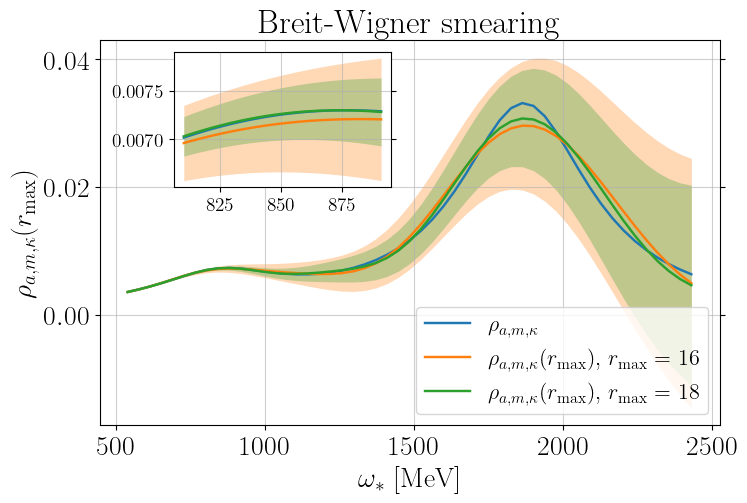

In [60]:
for ki in range(len(ker)):
    #plt.figure(figsize=(8,7))
    w = np.linspace(2, 9, 51)*270*0.065/197.3
    for si in range(len(rmax)):
        if rmax[si] == +np.inf:
            plt.plot(w/0.065*197.3, rho[ki, 0, si, :], label = r"$\rho_{a, m, \kappa}$")
        else:
            line, = plt.plot(w/0.065*197.3, rho[ki, 0, si, :], label = r"$\rho_{a, m, \kappa}(r_\mathrm{max})$, $r_\mathrm{max} = \,\,$"+r"${}$".format(rmax[si]))
            plt.fill_between(w/0.065*197.3, rho[ki, 0, si, :]-err_rho[ki, 0, si-1, :], rho[ki, 0, si, :]+err_rho[ki, 0, si-1, :], alpha = 0.3, color = line.get_color(), linewidth=0)
    plt.legend(loc="lower right", fontsize = 16)
    plt.xlabel(r"$\omega_*$ [MeV]")
    plt.ylabel(r"$\rho_{a, m, \kappa}(r_\mathrm{max})$")
    plt.title(ker[ki] + " smearing", fontsize = 24)
    #plt.tight_layout()
    #b, t = plt.ylim()
    #plt.ylim(0, 0.15)
    ax = plt.gca()
    ins = ax.inset_axes([0.12, 0.62, 0.35, 0.35])
    w = np.linspace(3, 3.3, 51)*270*0.065/197.3
    for si in range(len(rmax)):
        if rmax[si] == +np.inf:
            ins.plot(w/0.065*197.3, rho_zoom[ki, 0, si, :], label = r"$\rho_{m. \kappa}$")
        else:
            line, = ins.plot(w/0.065*197.3, rho_zoom[ki, 0, si, :])
            ins.fill_between(w/0.065*197.3, rho_zoom[ki, 0, si, :]-err_rho_zoom[ki, 0, si-1, :], rho_zoom[ki, 0, si, :]+err_rho_zoom[ki, 0, si-1, :], alpha = 0.3, color = line.get_color(), linewidth=0)
    ins.tick_params(axis='both', which='major', labelsize=14)
    #ins.set_ylim(0.067, 0.073)
    plt.show()